In [12]:
from typing import List, Sequence, Tuple
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

def brier_scores(df: pd.DataFrame) -> List[pd.Series]:
    """
    Compute and plot daily Brier scores for each CV fold and their ensemble mean.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
          - 'date' (datetime or date)
          - 'target' (0 or 1)
          - one or more 'pred_foldX' columns with predictions in [0,1]

    Returns
    -------
    List[pd.Series]
        A list of daily‐averaged Brier score time series:
        one for each fold (in order of pred_fold columns),
        and a final entry for the ensemble mean prediction.
    """
    df = df.copy()
    plt.figure(figsize=(14, 6))

    brier_series: List[pd.Series] = []
    pred_cols = [c for c in df.columns if c.startswith("pred_fold")]

    # Compute per‐fold Brier scores
    for i, col in enumerate(pred_cols, start=1):
        score_col = f"fold{i}_brier"
        df[score_col] = (df["target"] - df[col]) ** 2
        daily_avg = df.groupby("date")[score_col].mean()
        plt.plot(daily_avg, label=f"Fold {i} Brier")
        brier_series.append(daily_avg)

    # Compute ensemble mean prediction if not present
    if "mean_fold_pred" not in df.columns:
        df["mean_fold_pred"] = df[pred_cols].mean(axis=1)

    # Compute Brier score for ensemble mean
    df["mean_brier"] = (df["target"] - df["mean_fold_pred"]) ** 2
    daily_mean = df.groupby("date")["mean_brier"].mean()
    plt.plot(daily_mean, label="Mean Brier")
    brier_series.append(daily_mean)

    # Baseline line (random forecast Brier = 0.25 for binary 0/1)
    plt.axhline(0.25, color="black", linestyle="--", label="Baseline 0.25")

    # Final plot touches
    plt.title("Daily Brier Scores by Fold")
    plt.xlabel("Date")
    plt.ylabel("Brier Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return brier_series

In [13]:
from typing import Tuple
import numpy as np
import pandas as pd

def compute_perf_stats(
    daily_ret: pd.Series,
    trading_days: int = 252,
    mar: float = 0.0,
    scaled: bool = False
) -> pd.Series:
    """
    Compute performance stats for a daily-return series.

    If scaled=False, treats daily_ret as true fractional returns and
      compounds them: wealth = (1+daily_ret).cumprod().
    If scaled=True, treats daily_ret as additive P&L (e.g. sigma‐scaled)
      and uses wealth = daily_ret.cumsum().

    Returns:
      ann_return, ann_vol, Sharpe, Sortino, Max_Drawdown
    """
    if scaled:
        # additive P&L curve
        wealth = daily_ret.cumsum()
        # annualized return = mean daily P&L * trading days
        ann_ret = daily_ret.mean() * trading_days
    else:
        # geometric wealth curve
        wealth = (1 + daily_ret).cumprod()
        # geometric annual return
        ann_ret = wealth.iloc[-1]**(trading_days/len(wealth)) - 1

    # annualized vol
    ann_vol = daily_ret.std(ddof=1) * np.sqrt(trading_days)

    # Sharpe (assume rf=0)
    sharpe = ann_ret / ann_vol if ann_vol else np.nan

    # Sortino: downside relative to MAR
    mar_daily = (1 + mar)**(1/trading_days) - 1 if not scaled else mar/trading_days
    # for scaled, treat mar as annual‐scaled P&L
    diffs = daily_ret - mar_daily
    downs = diffs[diffs < 0]
    # annualized downside vol
    dvol = np.sqrt((downs**2).mean()) * np.sqrt(trading_days)
    sortino = (ann_ret - mar) / dvol if dvol else np.nan

    # Max drawdown on wealth curve
    if scaled:
        peak = wealth.cummax()
        dd   = wealth - peak
    else:
        peak = wealth.cummax()
        dd   = (wealth - peak) / peak
    max_dd = dd.min()

    return pd.Series({
        "ann_return":   ann_ret,
        "ann_vol":      ann_vol,
        "Sharpe":       sharpe,
        "Sortino":      sortino,
        "Max_Drawdown": max_dd
    })

In [14]:
from typing import Sequence, Tuple
import pandas as pd
import matplotlib.pyplot as plt

def plot_mean_brier_train_oos(
    train_brier: Sequence[pd.Series],
    oos_brier: Sequence[pd.Series],
    baseline: float = 0.25,
    figsize: Tuple[int, int] = (14, 6)
) -> None:
    """
    Plot the mean daily Brier score for training vs. out-of-sample.

    Parameters
    ----------
    train_brier : Sequence[pd.Series]
        A list of daily‐averaged Brier score series for each fold on the training set.
        The **last** element is taken as the overall “mean Brier” for train.
    oos_brier : Sequence[pd.Series]
        A list of daily‐averaged Brier score series for each fold on the held-out set.
        The **last** element is taken as the overall “mean Brier” for OOS.
    baseline : float, default 0.25
        The horizontal baseline Brier score to plot (e.g. random-forecast level).
    figsize : Tuple[int, int], default (14, 6)
        Figure size in inches for the matplotlib plot.

    Returns
    -------
    None
    """
    # Extract the “mean” Brier curves (last element of each list)
    train_mean = train_brier[-1]
    oos_mean   = oos_brier[-1]

    plt.figure(figsize=figsize)
    plt.plot(train_mean.index, train_mean.values,
             label="Train – mean Brier", color="blue")
    plt.plot(oos_mean.index,   oos_mean.values,
             label="OOS – mean Brier",   color="green")
    plt.axhline(baseline, color="black", linestyle="--",
                label=f"Baseline {baseline}")

    plt.title("Mean Brier Score: Train vs OOS")
    plt.xlabel("Date")
    plt.ylabel("Brier Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [15]:
from typing import Callable, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from IPython.display import display

def full_strategy_report(
    pre_open_test: pd.DataFrame,
    compute_perf_stats: Callable[[pd.Series, bool], pd.Series]
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Do everything and display in this order:
      1) Simple‐return P&L plot + stats
      2) σ‐scaled P&L plot + stats
      3) σ‐scaled leg plot + leg stats
      4) Round‐trip + precision table
    """
    df = pre_open_test.copy()

    # ── 1) SIMPLE‐RETURN STRATEGY ────────────────────────────────────────
    df['strat_ret_simple'] = df['return_pct'] * df['pred']
    df['bh_ret_simple']    = df['return_pct']
    d_strat_simple = df.groupby('date')['strat_ret_simple'].mean()
    d_bh_simple    = df.groupby('date')['bh_ret_simple'].mean()

    stats_simple = pd.DataFrame({
        'Strategy':   compute_perf_stats(d_strat_simple, scaled=False),
        'Buy & Hold': compute_perf_stats(d_bh_simple,    scaled=False)
    }).T

    # 1a) plot simple‐return
    plt.figure(figsize=(10,4))
    (1 + d_bh_simple).cumprod().plot(label='Buy & Hold', lw=2, alpha=0.7)
    (1 + d_strat_simple).cumprod().plot(label='Strategy',    lw=2)
    plt.title("Raw‐Return P&L (start = 1.0)")
    plt.xlabel("Date"); plt.ylabel("Wealth")
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # 1b) display stats
    display(stats_simple)

    # ── 2) σ-SCALED STRATEGY ─────────────────────────────────────────────
    df['strat_ret_sigma'] = df['return_scaled'] * df['pred']
    df['bh_ret_sigma']    = df['return_scaled']
    d_strat_sigma = df.groupby('date')['strat_ret_sigma'].mean()
    d_bh_sigma    = df.groupby('date')['bh_ret_sigma'].mean()

    stats_sigma = pd.DataFrame({
        'Strategy':   compute_perf_stats(d_strat_sigma, scaled=True),
        'Buy & Hold': compute_perf_stats(d_bh_sigma,    scaled=True)
    }).T

    # 2a) plot σ-scaled
    plt.figure(figsize=(10,4))
    (d_bh_sigma.cumsum()).plot(label='Buy & Hold', lw=2, alpha=0.7)
    (d_strat_sigma.cumsum()).plot(label='Strategy',    lw=2)
    plt.title("σ-Scaled P&L (start = 1.0)")
    plt.xlabel("Date"); plt.ylabel("Index (σ-units)")
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # 2b) display stats
    display(stats_sigma)

    # ── 3) σ-SCALED LEGS ─────────────────────────────────────────────────
    all_dates = d_strat_simple.index
    simple_df = df.drop(columns=[c for c in df if c.startswith('emb_')])

    d_long_s = (simple_df[simple_df['pred']==1]
                .groupby('date')['return_scaled'].mean()
                .reindex(all_dates, fill_value=0))
    d_short_s = (simple_df[simple_df['pred']==-1]
                 .groupby('date')['return_scaled'].mean().mul(-1)
                 .reindex(all_dates, fill_value=0))

    # 3a) plot legs
    plt.figure(figsize=(10,4))
    (d_long_s.cumsum()).plot(label='Long Leg σ',  lw=2, color='green')
    (d_short_s.cumsum()).plot(label='Short Leg σ', lw=2, color='red')
    plt.title("Legs – σ-Scaled P&L")
    plt.xlabel("Date"); plt.ylabel("Index (σ-units)")
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # 3b) leg stats
    stats_legs_sigma = pd.DataFrame({
        'Long Leg σ':  compute_perf_stats(d_long_s,  scaled=True),
        'Short Leg σ': compute_perf_stats(d_short_s, scaled=True),
    }).T
    display(stats_legs_sigma)

    # ── 4) ROUND-TRIP + PRECISION TABLE ────────────────────────────────────
    longs_true   = simple_df[(simple_df['target']==1)  & (simple_df['pred']==1)]
    longs_false  = simple_df[(simple_df['target']==0)  & (simple_df['pred']==1)]
    shorts_true  = simple_df[(simple_df['target']==0)  & (simple_df['pred']==-1)]
    shorts_false = simple_df[(simple_df['target']==1)  & (simple_df['pred']==-1)]
    longs_all    = simple_df[simple_df['target']==1]
    shorts_all   = simple_df[simple_df['target']==0]

    rt_data = {
        "True Longs":   (longs_true['strat_ret_simple'].mean(),  len(longs_true)),
        "False Shorts": (shorts_false['strat_ret_simple'].mean(), len(shorts_false)),
        "True Shorts":  (shorts_true['strat_ret_simple'].mean(),  len(shorts_true)),
        "False Longs":  (longs_false['strat_ret_simple'].mean(), len(longs_false)),
        "Actual Longs": (longs_all['return_pct'].mean(),          len(longs_all)),
        "Actual Shorts":(shorts_all['return_pct'].mean(),        len(shorts_all)),
    }
    rt_df = pd.DataFrame.from_dict(
        {k: {'Avg Return':v[0], 'Count':v[1]} for k,v in rt_data.items()},
        orient='index'
    )

    y_true  = simple_df['target'].astype(int)
    y_pred  = (simple_df['pred']==1).astype(int)
    wgt     = simple_df['sample_weight']

    prec_long   = precision_score(y_true, y_pred, pos_label=1)
    prec_short  = precision_score(y_true, y_pred, pos_label=0)
    prec_long_w = precision_score(y_true, y_pred, pos_label=1, sample_weight=wgt)
    prec_short_w= precision_score(y_true, y_pred, pos_label=0, sample_weight=wgt)

    cnt_long  = int((y_pred==1).sum())
    cnt_short = int((y_pred==0).sum())

    prec_data = {
        "Predicted Longs": {'Avg Return':np.nan, 'Count':cnt_long,
                            'Precision':prec_long,  'Weighted Precision':prec_long_w},
        "Predicted Shorts":{'Avg Return':np.nan, 'Count':cnt_short,
                            'Precision':prec_short, 'Weighted Precision':prec_short_w},
    }
    prec_df = pd.DataFrame.from_dict(prec_data, orient='index')

    final_table = pd.concat([rt_df, prec_df], axis=0)
    display(final_table)

    return stats_simple, stats_sigma, stats_legs_sigma, final_table

In [16]:
last_h_test = pd.read_parquet(import_path+"last_h_test.parquet")
last_h_train = pd.read_parquet(import_path+"last_h_train.parquet")

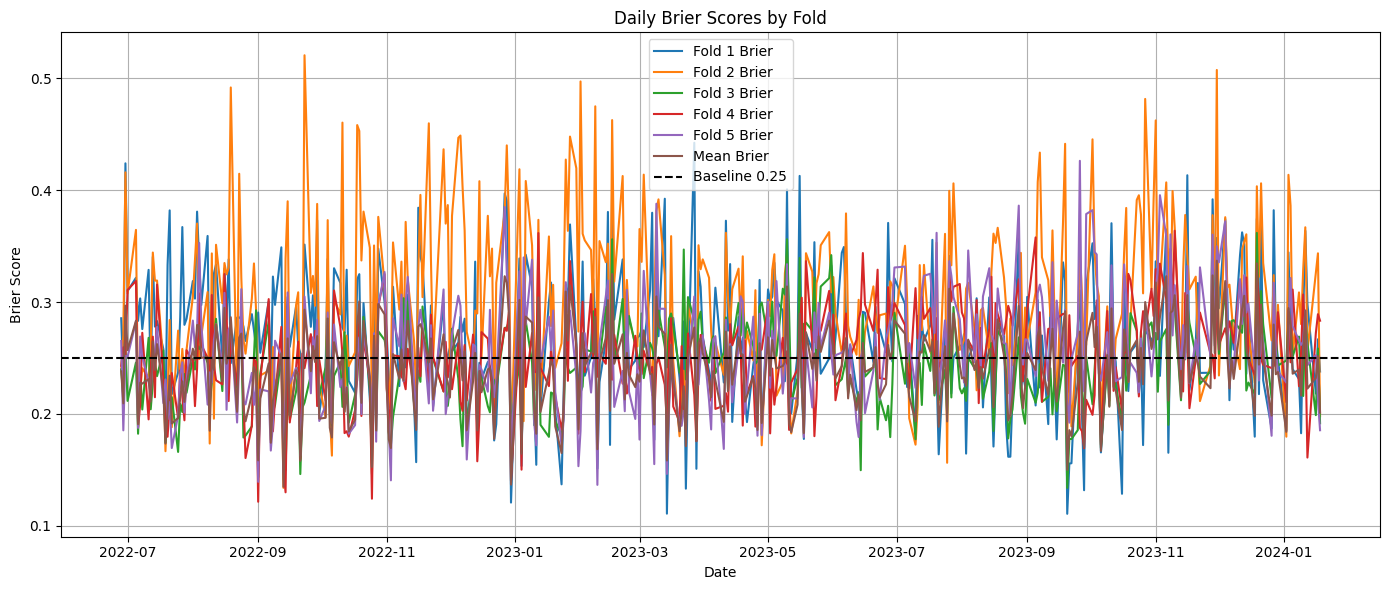

In [17]:
folds_brie_train = brier_scores(last_h_train)

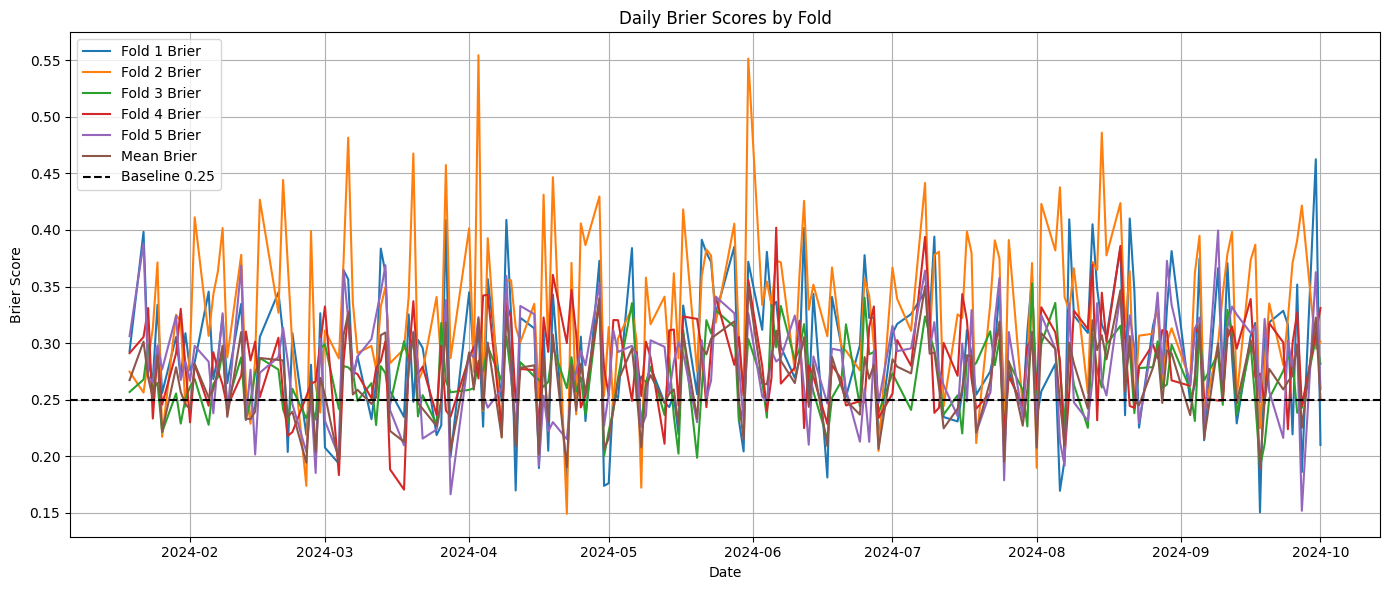

In [18]:
folds_brie_test = brier_scores(last_h_test)

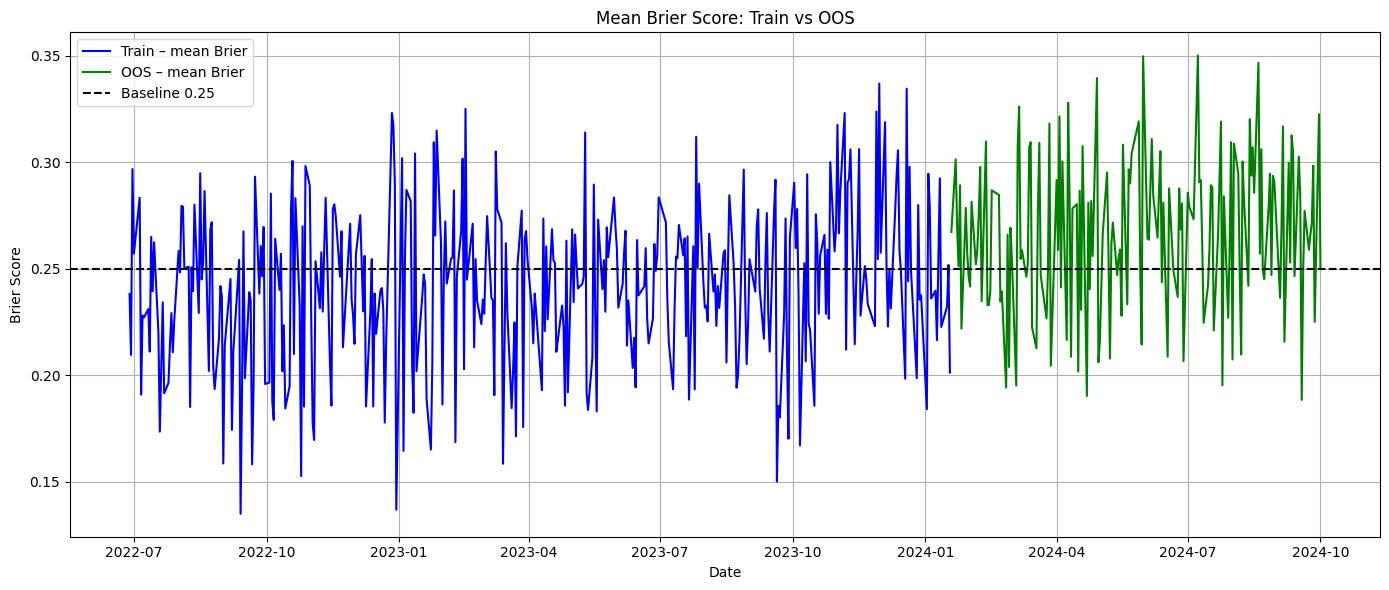

In [19]:
plot_mean_brier_train_oos(train_brier=folds_brie_train,oos_brier= folds_brie_test,)


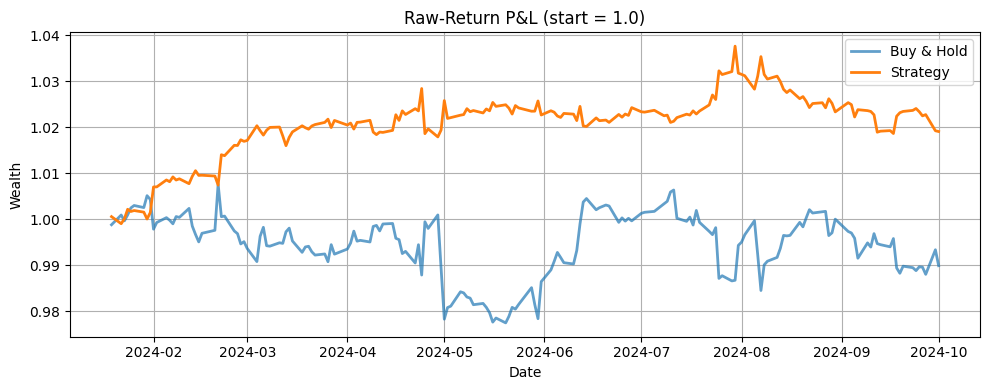

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown
Strategy,0.027441,0.030589,0.897079,0.934258,-0.018301
Buy & Hold,-0.014397,0.050472,-0.285249,-0.266144,-0.029934


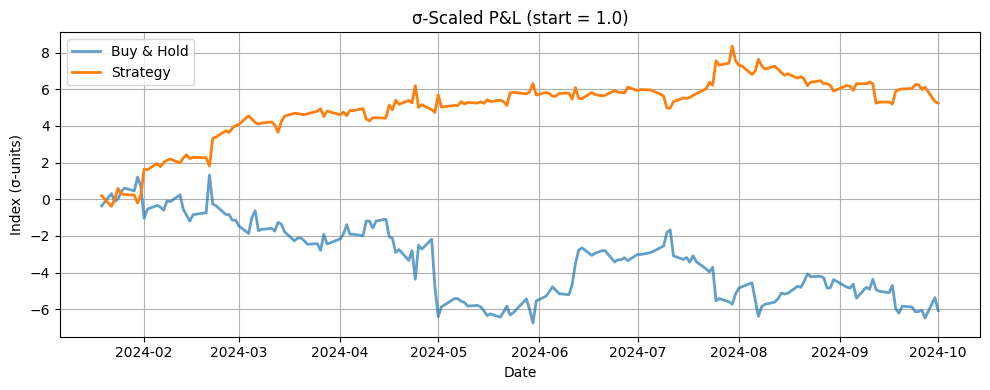

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown
Strategy,7.498982,5.835299,1.285107,1.479502,-3.152716
Buy & Hold,-8.689426,9.311762,-0.933167,-0.842011,-8.058670


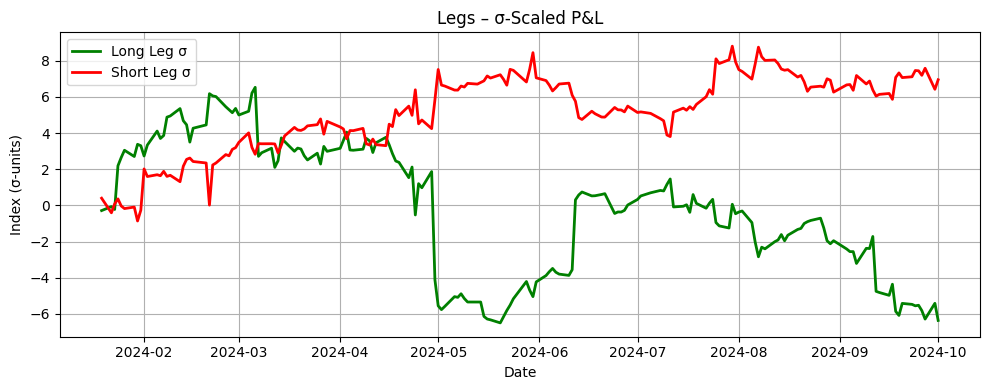

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown
Long Leg σ,-9.108468,14.069440,-0.647394,-0.554523,-13.032091
Short Leg σ,9.953873,9.619559,1.034754,1.194617,-4.642197


,Avg Return,Count,Precision,Weighted Precision
True Longs,0.004065,616,NaN,NaN
False Shorts,-0.003948,1653,NaN,NaN
True Shorts,0.004136,1665,NaN,NaN
False Longs,-0.003866,613,NaN,NaN
Actual Longs,0.003980,2269,NaN,NaN
Actual Shorts,-0.004063,2278,NaN,NaN
Predicted Longs,NaN,1229,0.501221,0.496327
Predicted Shorts,NaN,3318,0.501808,0.520516


In [20]:
stats_simple, stats_sigma, stats_legs_sigma, round_trips = full_strategy_report(
    last_h_test, compute_perf_stats
)
